<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/APTOS_FCN_clahe_Tuner_d3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File notes:

Model: CNN with hypertuning

Datasets:

APTOS (Train, Validation and Test) - images have been preprocessed externally via Contrast Limited AHE (CLAHE)

Kaggle (Test)

Best Hyperparameters:
{'activation': '**swish**', 'units': **320**, 'optimizer': '**adam**', 'learning_rate': **0.01**, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


Fitting optimized model:

The epoch with the lowest loss is: 10 (Loss: 0.8227)

The epoch with the lowest val_loss is: 11 (Val Loss: 0.8751)

The epoch with the highest accuracy is: 10 (Accuracy: 0.7046)

The epoch with the highest validation accuracy is: 11 (Val Accuracy: 0.6995)

The epoch with the highest MCC is: 10 (MCC: 0.5347)

The epoch with the highest validation MCC is: 11 (**Val MCC:** **0.5447**)




In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!pip install tensorflow-addons

In [4]:
!pip install h5py


In [5]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

In [6]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [7]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
#import tensorflow_addons as tfa
import os

import h5py

import json

import datetime

import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix,cohen_kappa_score, matthews_corrcoef, recall_score


from scikeras.wrappers import KerasClassifier, KerasRegressor

import keras
from tensorflow.keras.metrics import Metric
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.activations import swish
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [8]:
os.listdir('/content/drive/MyDrive/train')

['Mild', 'Moderate', 'No_DR', 'Proliferative_DR', 'Severe']

In [9]:
# To have reproducible results
seed = 27

np.random.seed(seed)

tf.random.set_seed(seed)

num_classes = 5

IMG_SIZE = (224,224)

In [10]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('/content/drive/MyDrive/train'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/train', i))
  for j in train_class:
    img = os.path.join('train', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))
print('Number of train labels : {} \n'.format(len(label)))

Number of train images : 3662 

Number of train labels : 3662 



In [11]:
img

'train/Severe/fb61230b99dd.png'

In [12]:
#os.listdir(os.path.join('/content/drive/MyDrive/train', 'Mild'))

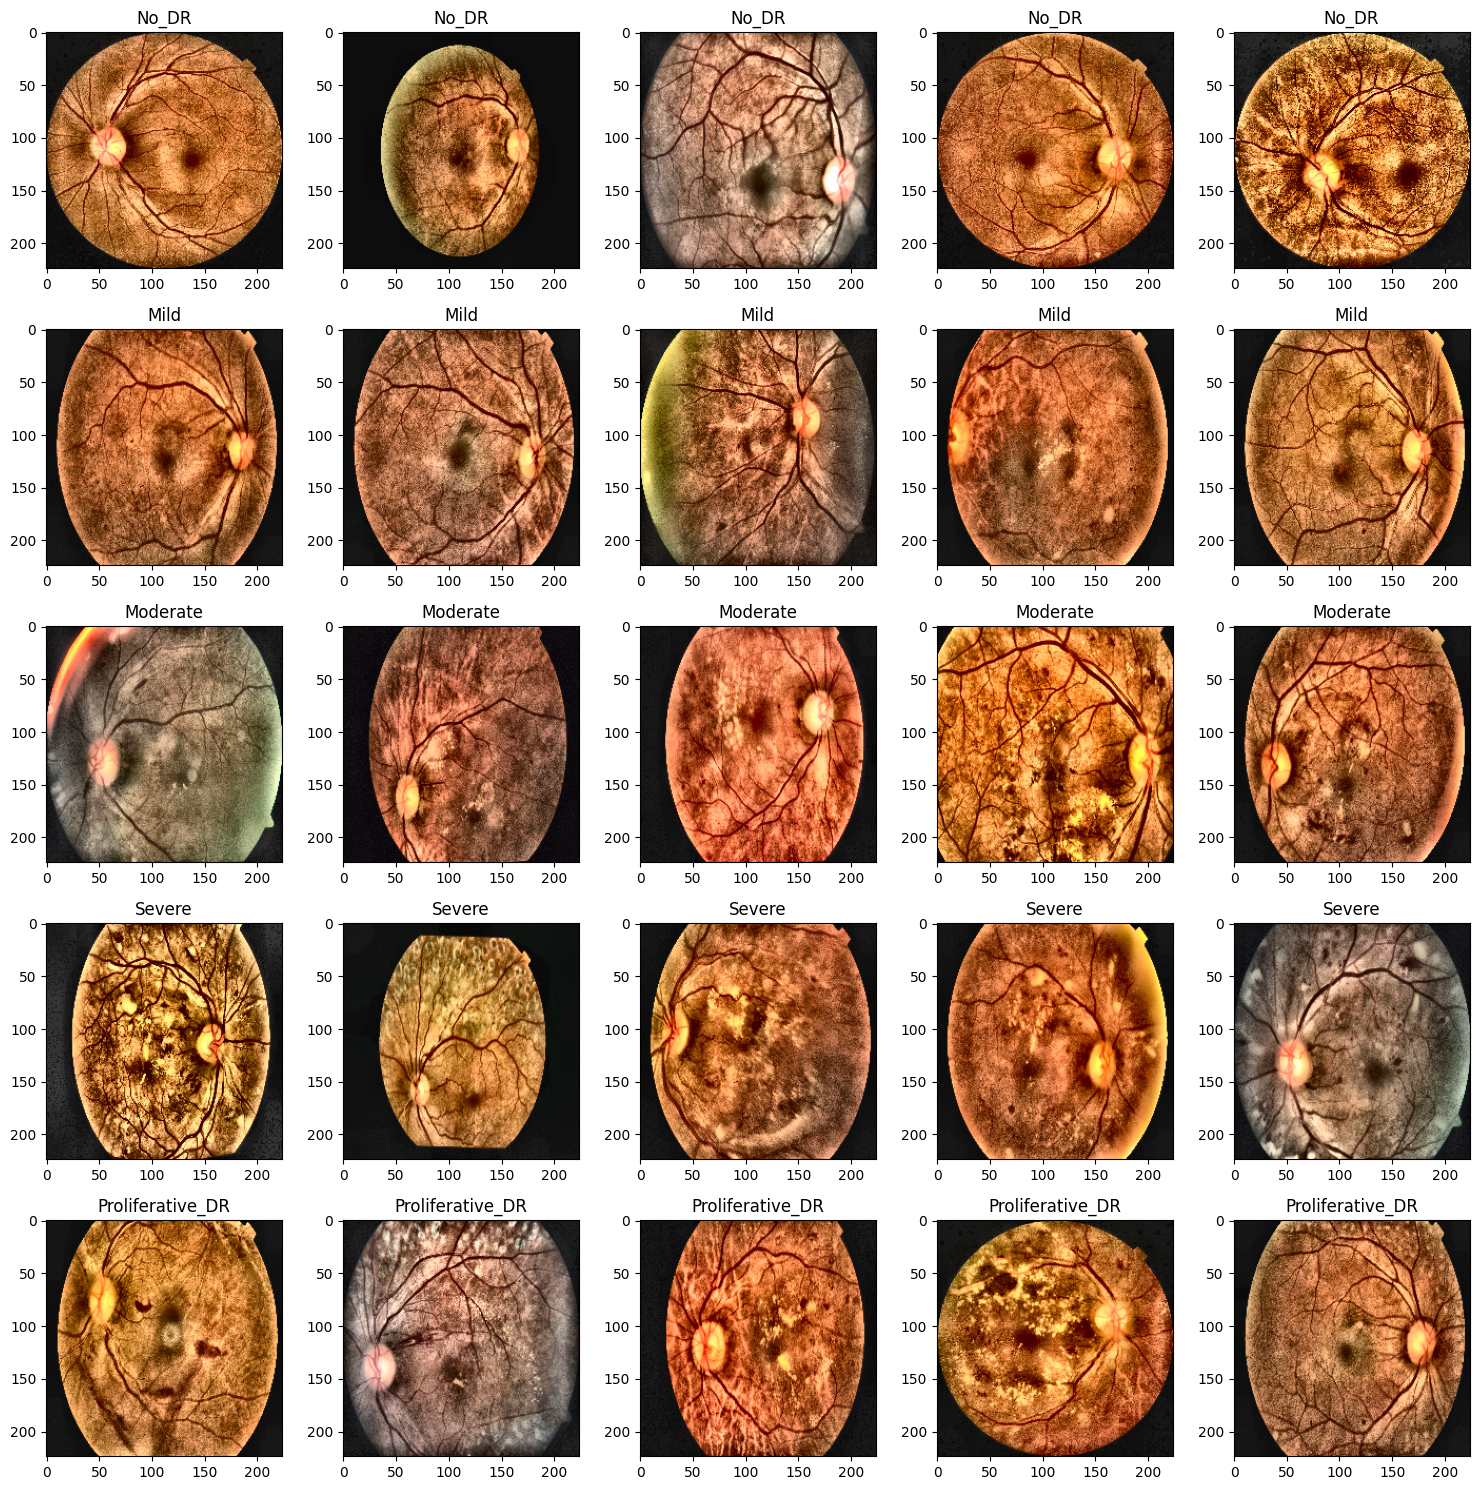

In [13]:
classes = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferative_DR']

fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Iterate over each class in the specified order
for count, cls in enumerate(classes):
    # Get the list of images in the current class
    class_path = os.path.join('/content/drive/MyDrive/train', cls)
    train_class = os.listdir(class_path)

    # Plot 5 images per class
    for j in range(5):
        img_path = os.path.join(class_path, train_class[j])
        img = PIL.Image.open(img_path)
        axs[count][j].title.set_text(cls)
        axs[count][j].imshow(img)

fig.tight_layout()
plt.show()

In [14]:
No_images_per_class = []
Class_name = []
for i in os.listdir('/content/drive/MyDrive/train'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/train', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Mild = 370 

Number of images in Moderate = 999 

Number of images in No_DR = 1805 

Number of images in Proliferative_DR = 295 

Number of images in Severe = 193 



In [15]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

Image  Labels
0       train/Mild/677f087cd697.png    Mild
1       train/Mild/ea15a290eb96.png    Mild
2       train/Mild/07929d32b5b3.png    Mild
3       train/Mild/35d6c4c50072.png    Mild
4       train/Mild/a5a2a7003d60.png    Mild
...                             ...     ...
3657  train/Severe/bb7e0a2544cd.png  Severe
3658  train/Severe/38055d8b9f08.png  Severe
3659  train/Severe/36b5b3c9fb32.png  Severe
3660  train/Severe/51269b77d312.png  Severe
3661  train/Severe/fb61230b99dd.png  Severe

[3662 rows x 2 columns]

In [16]:
# Shuffle the data and split it into training, testing and validation
retina_df = shuffle(retina_df)
train, test = train_test_split(retina_df, test_size = 0.3)
test = shuffle(test)
val, test = train_test_split(test, test_size = 0.5)

In [17]:
train_datagen =  ImageDataGenerator(
    zoom_range=0.15,  # set range for random zoom, changed from 0.15 to 0.3, now changed from 0.3 to 0.45, from 0.45 to 0.6
    fill_mode='constant',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,# randomly flip images
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1./255)


# For test datagenerator, we only normalize the data.
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
base_path = '/content/drive/My Drive/'  # Your base path

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

validation_generator = val_datagen.flow_from_dataframe(
    val,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

test_generator = test_datagen.flow_from_dataframe(
    test,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)


Found 2563 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [19]:
images, labels = next(test_generator)


In [20]:
example_image = images[0]
example_label = labels[0]

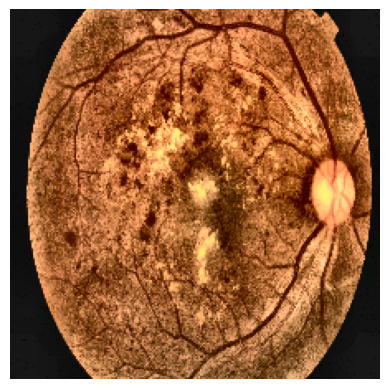

Label:  [0. 1. 0. 0. 0.]


In [21]:
plt.imshow(example_image)
plt.axis('off')  # To turn off the axis
plt.show()
print("Label: ",example_label)


In [22]:
class MatthewsCorrelationCoefficient(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="matthews_correlation_coefficient", **kwargs):
        super(MatthewsCorrelationCoefficient, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.confusion_matrix = self.add_weight(
            name="confusion_matrix",
            shape=(num_classes, num_classes),
            initializer="zeros"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)

        new_confusion_matrix = tf.math.confusion_matrix(y_true, y_pred, self.num_classes)
        new_confusion_matrix = tf.cast(new_confusion_matrix, self.confusion_matrix.dtype)

        return self.confusion_matrix.assign_add(new_confusion_matrix)

    def result(self):
        sum_over_row = tf.reduce_sum(self.confusion_matrix, axis=0)
        sum_over_col = tf.reduce_sum(self.confusion_matrix, axis=1)
        true_positives = tf.linalg.diag_part(self.confusion_matrix)
        predicted_positives = sum_over_row
        actual_positives = sum_over_col
        total_samples = tf.reduce_sum(sum_over_row)

        mcc_numerator = tf.reduce_sum(true_positives * total_samples - predicted_positives * actual_positives)
        mcc_denominator = tf.sqrt(
            (total_samples**2 - tf.reduce_sum(predicted_positives**2)) *
            (total_samples**2 - tf.reduce_sum(actual_positives**2))
        )

        mcc = mcc_numerator / mcc_denominator
        mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
        return mcc

    def reset_state(self):
        for s in self.variables:
            s.assign(tf.zeros_like(s))

    def get_config(self):
        config = super(MatthewsCorrelationCoefficient, self).get_config()
        config.update({"num_classes": self.num_classes})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

mcc_metric = MatthewsCorrelationCoefficient(num_classes)

In [23]:
def create_model(hp):
    model = Sequential()
    activation_choice = hp.Choice('activation', ['LeakyReLU', 'relu', 'swish'])

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation=activation_choice, input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Block
    model.add(Conv2D(32, (3, 3), activation=activation_choice))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Block
    model.add(Conv2D(64, (3, 3), activation=activation_choice))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten before Dense Layers
    model.add(Flatten())

    # Tunable Dense Layer
    hp_units = hp.Int('units', min_value=32, max_value=512, step=48)
    model.add(Dense(units=hp_units, activation=activation_choice))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(5, activation='softmax'))

    # Compile Model
    hp_optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    # Dynamically set the optimizer
    if hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)

    model.compile(optimizer=hp_optimizer, loss='categorical_crossentropy', metrics=['accuracy', mcc_metric])

    return model


In [24]:
# Early stopping callback
stop_early = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

# Hyperparameter tuning setup
tuner = kt.Hyperband(
    create_model,
    objective=kt.Objective('val_accuracy', direction='max'),
    max_epochs=10,
    directory='/content/drive/MyDrive/savedmodels',
    project_name='dr_tuningd3'
)

# Start tuning
tuner.search(train_generator, epochs=10, validation_data=validation_generator, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build and train the best model
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[stop_early])

# Save the model
model.save('/content/drive/MyDrive/savedmodels/modeld3.keras')

# Save the training history
with open('/content/drive/MyDrive/savedmodels/historyd3.json', 'w') as f:
    json.dump(history.history, f)

print("Training completed")


Trial 30 Complete [00h 05m 29s]
val_accuracy: 0.686703085899353

Best val_accuracy So Far: 0.7140254974365234
Total elapsed time: 01h 38m 31s
Epoch 1/50
81/81 [==============================] - 34s 400ms/step - loss: 1.2216 - accuracy: 0.5408 - matthews_correlation_coefficient: 0.2692 - val_loss: 0.9691 - val_accuracy: 0.6339 - val_matthews_correlation_coefficient: 0.4325
Epoch 2/50
81/81 [==============================] - 32s 397ms/step - loss: 1.0375 - accuracy: 0.6231 - matthews_correlation_coefficient: 0.3784 - val_loss: 0.9657 - val_accuracy: 0.6576 - val_matthews_correlation_coefficient: 0.4759
Epoch 3/50
81/81 [==============================] - 33s 402ms/step - loss: 0.9482 - accuracy: 0.6570 - matthews_correlation_coefficient: 0.4449 - val_loss: 0.8968 - val_accuracy: 0.6594 - val_matthews_correlation_coefficient: 0.4708
Epoch 4/50
81/81 [==============================] - 32s 395ms/step - loss: 0.9018 - accuracy: 0.6762 - matthews_correlation_coefficient: 0.4813 - val_loss: 0.8

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 64)       

In [26]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for hyperparam in best_hps.values:
    print(f"{hyperparam}: {best_hps.get(hyperparam)}")

Best Hyperparameters:
activation: swish
units: 368
optimizer: adam
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0


Best Hyperparameters:
{'activation': 'swish', 'units': 368, 'optimizer': 'adam', 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


<ipython-input-27-4ccd894c03c0>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 1)
<ipython-input-27-4ccd894c03c0>:29: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 2, 3)


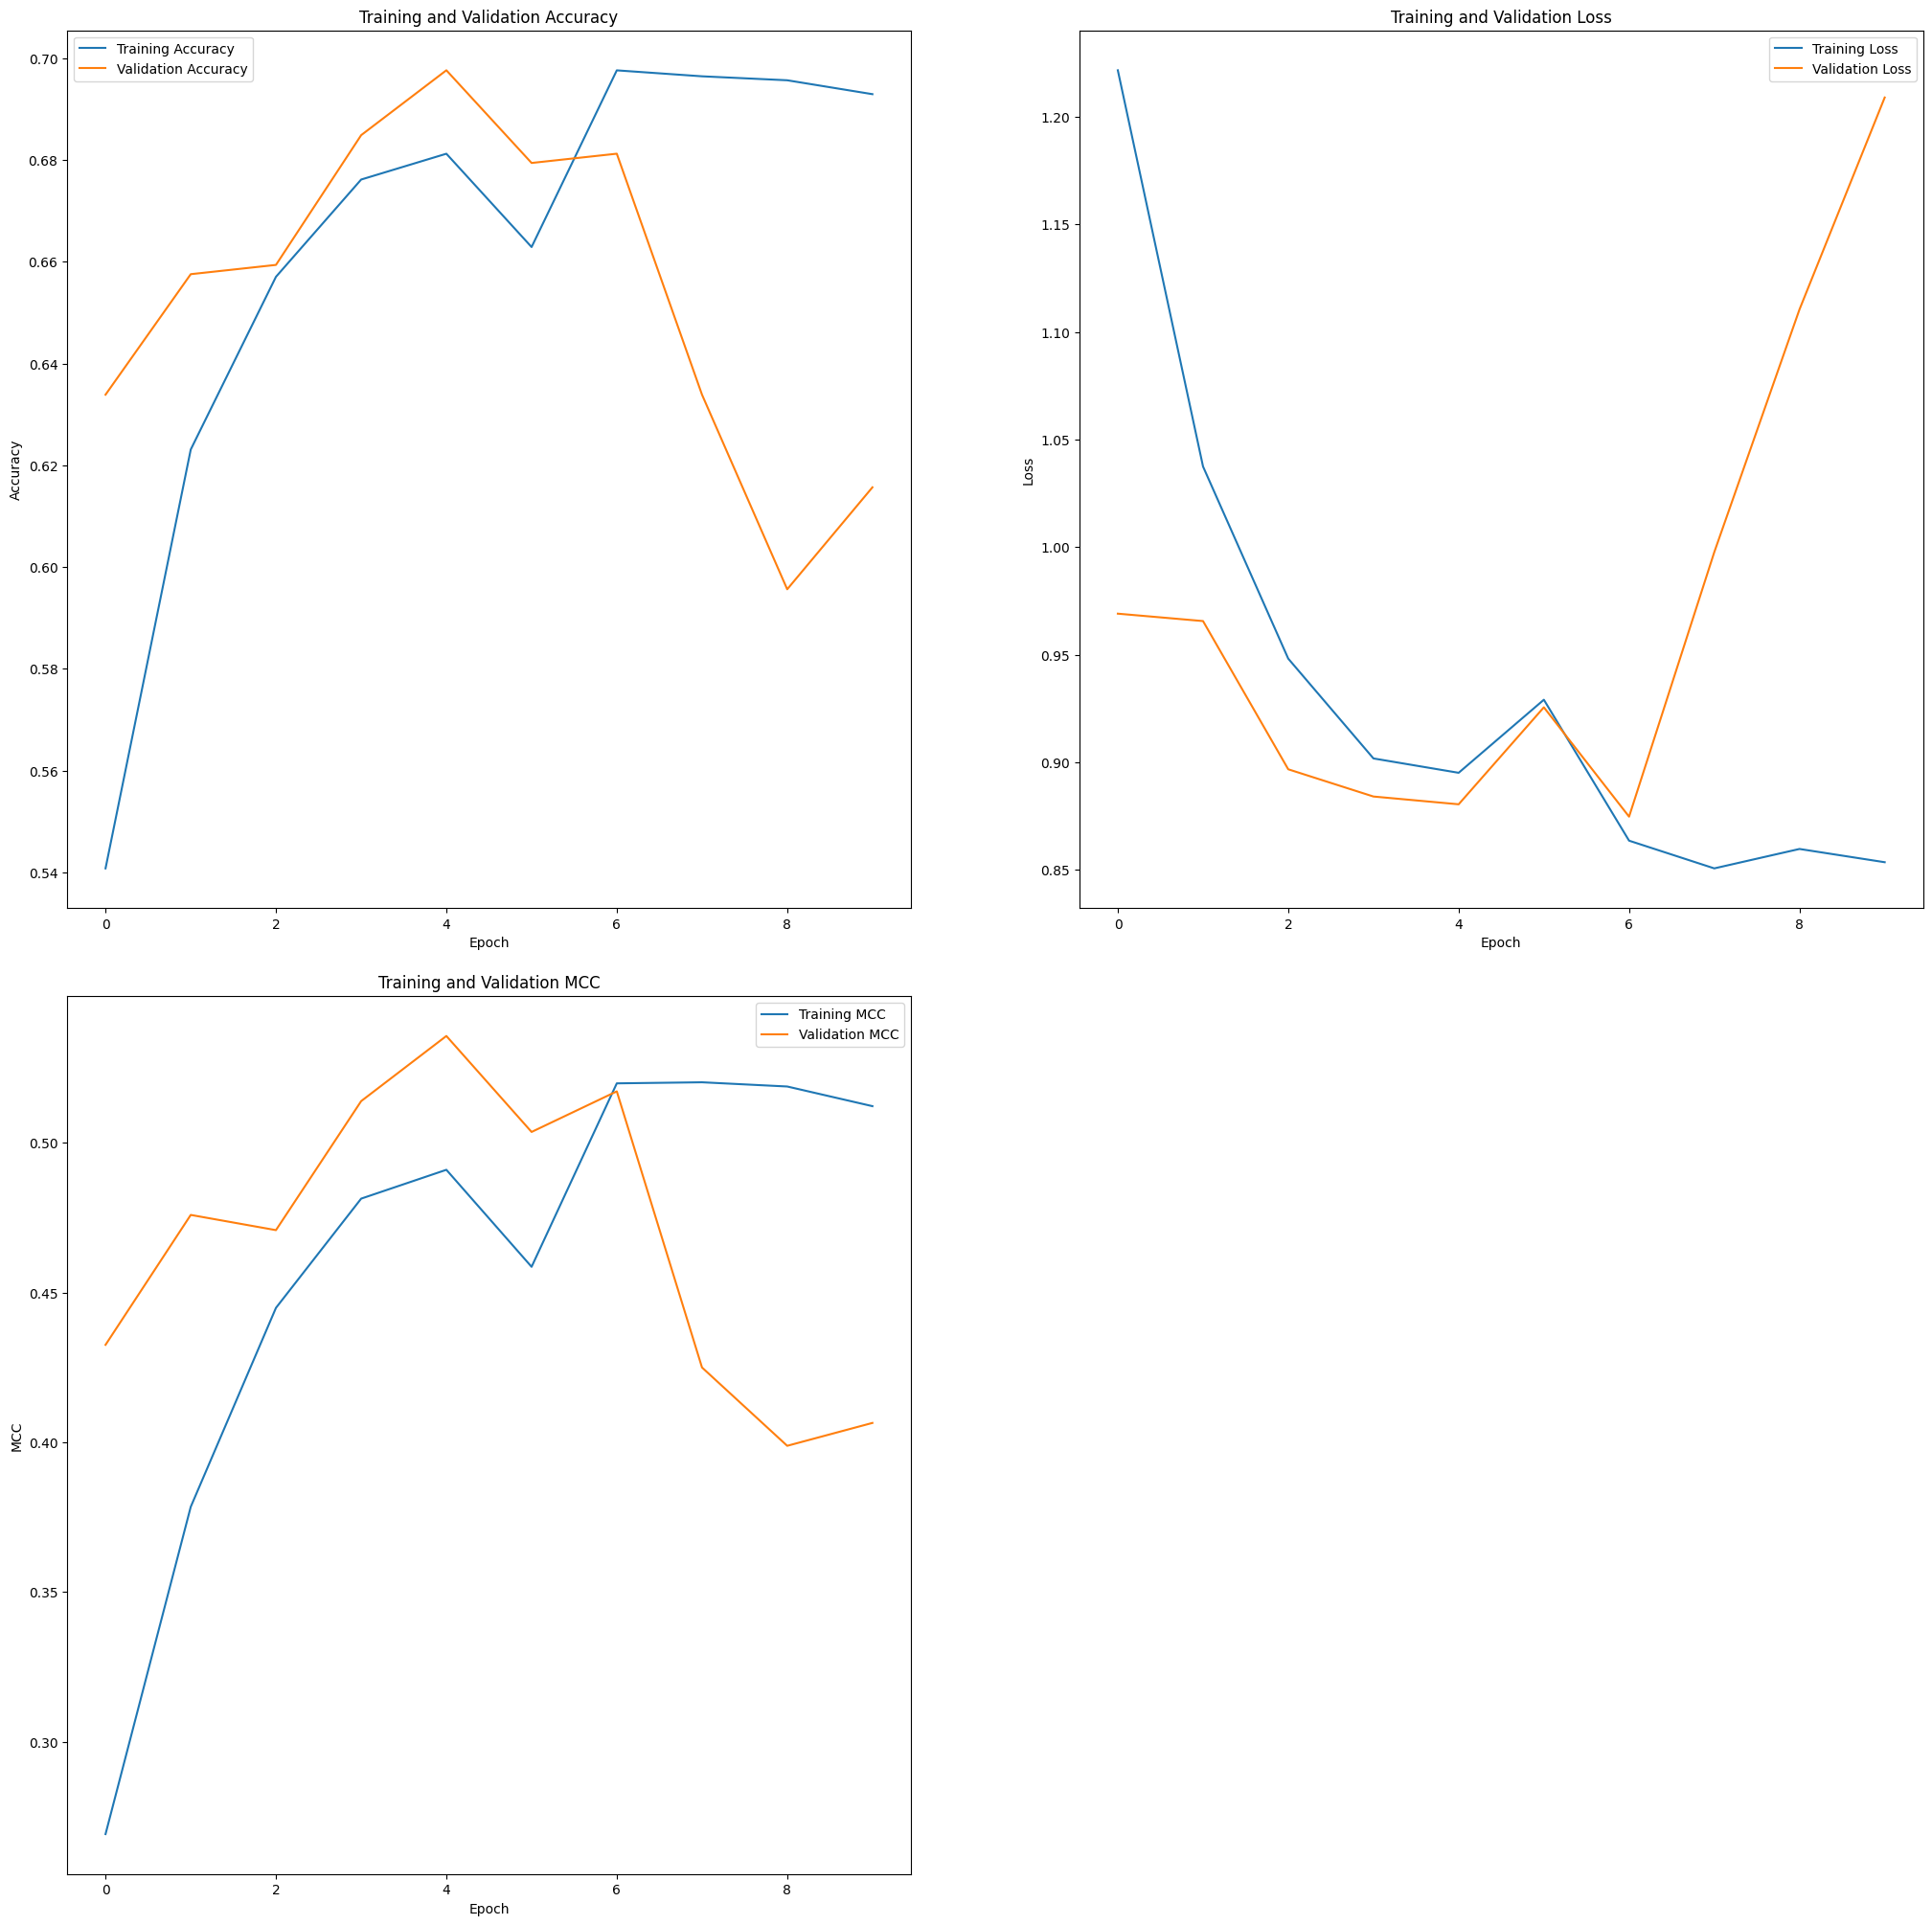

In [27]:

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps.values)

fig, axs = plt.subplots(3, 1, figsize=(25,25))

# Plot training and validation accuracy

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss

plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation MCC

plt.subplot(2, 2, 3)
plt.plot(history.history['matthews_correlation_coefficient'], label='Training MCC')
plt.plot(history.history['val_matthews_correlation_coefficient'], label='Validation MCC')
plt.title('Training and Validation MCC')
plt.xlabel('Epoch')
plt.ylabel('MCC')
plt.legend()

plt.subplots_adjust(hspace=0.1)

plt.show()


In [28]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hps.values)

# Loss
min_loss_index = np.argmin(history.history['loss'])
min_loss_value = round(history.history['loss'][min_loss_index], 4)
print(f'The epoch with the lowest loss is: {min_loss_index + 1} (Loss: {min_loss_value})')

# Validation Loss
min_val_loss_index = np.argmin(history.history['val_loss'])
min_val_loss_value = round(history.history['val_loss'][min_val_loss_index], 4)
print(f'The epoch with the lowest val_loss is: {min_val_loss_index + 1} (Val Loss: {min_val_loss_value})')

# Accuracy
max_accuracy_index = np.argmax(history.history['accuracy'])
max_accuracy_value = round(history.history['accuracy'][max_accuracy_index], 4)
print(f'The epoch with the highest accuracy is: {max_accuracy_index + 1} (Accuracy: {max_accuracy_value})')

# Validation Accuracy
max_val_acc_index = np.argmax(history.history['val_accuracy'])
max_val_acc_value = round(history.history['val_accuracy'][max_val_acc_index], 4)
print(f'The epoch with the highest validation accuracy is: {max_val_acc_index + 1} (Val Accuracy: {max_val_acc_value})')

# Matthews Correlation Coefficient (MCC)
max_mcc_index = np.argmax(history.history['matthews_correlation_coefficient'])
max_mcc_value = round(history.history['matthews_correlation_coefficient'][max_mcc_index], 4)
print(f'The epoch with the highest MCC is: {max_mcc_index + 1} (MCC: {max_mcc_value})')

# Validation MCC
max_val_mcc_index = np.argmax(history.history['val_matthews_correlation_coefficient'])
max_val_mcc_value = round(history.history['val_matthews_correlation_coefficient'][max_val_mcc_index], 4)
print(f'The epoch with the highest validation MCC is: {max_val_mcc_index + 1} (Val MCC: {max_val_mcc_value})')

best_epoch_count=max_val_mcc_index + 1
print(best_epoch_count)

Best Hyperparameters:
{'activation': 'swish', 'units': 368, 'optimizer': 'adam', 'learning_rate': 0.001, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
The epoch with the lowest loss is: 8 (Loss: 0.8507)
The epoch with the lowest val_loss is: 7 (Val Loss: 0.8748)
The epoch with the highest accuracy is: 7 (Accuracy: 0.6976)
The epoch with the highest validation accuracy is: 5 (Val Accuracy: 0.6976)
The epoch with the highest MCC is: 8 (MCC: 0.5201)
The epoch with the highest validation MCC is: 5 (Val MCC: 0.5356)
5


In [29]:

stop_early = EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

# Rebuild the model with the best hyperparameters
modelt = tuner.hypermodel.build(best_hps)

# Train the model using only the training data
# Replace 'train_generator' with your training data generator
historyt=modelt.fit(train_generator, epochs=best_epoch_count, callbacks=[stop_early], validation_data=validation_generator)

# Evaluate the model on the test set
test_loss, test_accuracy, test_mcc = modelt.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test MCC: {test_mcc}")



Epoch 1/5
81/81 [==============================] - 34s 401ms/step - loss: 1.2585 - accuracy: 0.5310 - matthews_correlation_coefficient: 0.2237 - val_loss: 0.9613 - val_accuracy: 0.6794 - val_matthews_correlation_coefficient: 0.5098
Epoch 2/5
81/81 [==============================] - 33s 402ms/step - loss: 1.0003 - accuracy: 0.6469 - matthews_correlation_coefficient: 0.4223 - val_loss: 0.9636 - val_accuracy: 0.6648 - val_matthews_correlation_coefficient: 0.4842
Epoch 3/5
81/81 [==============================] - 32s 399ms/step - loss: 0.9389 - accuracy: 0.6606 - matthews_correlation_coefficient: 0.4504 - val_loss: 0.9339 - val_accuracy: 0.6922 - val_matthews_correlation_coefficient: 0.5254
Epoch 4/5
81/81 [==============================] - 33s 405ms/step - loss: 0.9135 - accuracy: 0.6648 - matthews_correlation_coefficient: 0.4624 - val_loss: 0.9559 - val_accuracy: 0.6812 - val_matthews_correlation_coefficient: 0.5112
Epoch 5/5
18/18 [==============================] - 324s 19s/step - loss:

In [30]:
# Loss
min_loss_index = np.argmin(historyt.history['loss'])
min_loss_value = round(historyt.history['loss'][min_loss_index], 4)
print(f'The epoch with the lowest loss is: {min_loss_index + 1} (Loss: {min_loss_value})')

# Validation Loss
min_val_loss_index = np.argmin(historyt.history['val_loss'])
min_val_loss_value = round(historyt.history['val_loss'][min_val_loss_index], 4)
print(f'The epoch with the lowest val_loss is: {min_val_loss_index + 1} (Val Loss: {min_val_loss_value})')

# Accuracy
max_accuracy_index = np.argmax(historyt.history['accuracy'])
max_accuracy_value = round(historyt.history['accuracy'][max_accuracy_index], 4)
print(f'The epoch with the highest accuracy is: {max_accuracy_index + 1} (Accuracy: {max_accuracy_value})')

# Validation Accuracy
max_val_acc_index = np.argmax(historyt.history['val_accuracy'])
max_val_acc_value = round(historyt.history['val_accuracy'][max_val_acc_index], 4)
print(f'The epoch with the highest validation accuracy is: {max_val_acc_index + 1} (Val Accuracy: {max_val_acc_value})')

# Matthews Correlation Coefficient (MCC)
max_mcc_index = np.argmax(historyt.history['matthews_correlation_coefficient'])
max_mcc_value = round(historyt.history['matthews_correlation_coefficient'][max_mcc_index], 4)
print(f'The epoch with the highest MCC is: {max_mcc_index + 1} (MCC: {max_mcc_value})')

# Validation MCC
max_val_mcc_index = np.argmax(historyt.history['val_matthews_correlation_coefficient'])
max_val_mcc_value = round(historyt.history['val_matthews_correlation_coefficient'][max_val_mcc_index], 4)
print(f'The epoch with the highest validation MCC is: {max_val_mcc_index + 1} (Val MCC: {max_val_mcc_value})')

The epoch with the lowest loss is: 5 (Loss: 0.9096)
The epoch with the lowest val_loss is: 3 (Val Loss: 0.9339)
The epoch with the highest accuracy is: 5 (Accuracy: 0.6777)
The epoch with the highest validation accuracy is: 3 (Val Accuracy: 0.6922)
The epoch with the highest MCC is: 5 (MCC: 0.4842)
The epoch with the highest validation MCC is: 3 (Val MCC: 0.5254)


#Testing

In [60]:
# Evaluate the model on the test set
loss, accuracy, matthews_correlation_coefficient = modelt.evaluate(test_generator)
print('Test accuracy :', accuracy, 'Test MCC :', matthews_correlation_coefficient)

18/18 [==============================] - 2s 97ms/step - loss: 0.9393 - accuracy: 0.6782 - matthews_correlation_coefficient: 0.4796
Test accuracy : 0.6781818270683289 Test MCC : 0.4795573949813843


In [59]:
# Predict with the model on the test set
predictions = modelt.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Retrieve the true labels from the test generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys(),zero_division=0)
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


18/18 [==============================] - 2s 100ms/step
Classification Report:
                  precision    recall  f1-score   support

            Mild       0.06      0.06      0.06        53
        Moderate       0.28      0.30      0.29       145
           No_DR       0.51      0.65      0.58       275
Proliferative_DR       0.00      0.00      0.00        46
          Severe       0.00      0.00      0.00        31

        accuracy                           0.41       550
       macro avg       0.17      0.20      0.18       550
    weighted avg       0.34      0.41      0.37       550

Confusion Matrix:
[[  3  17  33   0   0]
 [ 11  43  91   0   0]
 [ 29  66 180   0   0]
 [  4  17  25   0   0]
 [  1   9  21   0   0]]


In [61]:

# Predict with the model on the test set
predictions = modelt.predict(test_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Retrieve the true labels from the test generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices.keys(),zero_division=0)
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

18/18 [==============================] - 2s 95ms/step
Classification Report:
                  precision    recall  f1-score   support

            Mild       0.12      0.11      0.12        53
        Moderate       0.25      0.26      0.26       145
           No_DR       0.49      0.63      0.55       275
Proliferative_DR       0.00      0.00      0.00        46
          Severe       0.00      0.00      0.00        31

        accuracy                           0.39       550
       macro avg       0.17      0.20      0.19       550
    weighted avg       0.33      0.39      0.36       550

Confusion Matrix:
[[  6  11  36   0   0]
 [ 15  38  92   0   0]
 [ 23  79 173   0   0]
 [  1  13  32   0   0]
 [  3  11  17   0   0]]


In [62]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Calculate the metrics with conditions to handle division by zero
TPR = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
TNR = np.divide(TN, TN + FP, out=np.zeros_like(TN), where=(TN+FP)!=0)
PPV = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
NPV = np.divide(TN, TN + FN, out=np.zeros_like(TN), where=(TN+FN)!=0)
FPR = np.divide(FP, FP + TN, out=np.zeros_like(FP), where=(FP+TN)!=0)
FNR = np.divide(FN, TP + FN, out=np.zeros_like(FN), where=(TP+FN)!=0)
FDR = np.divide(FP, TP + FP, out=np.zeros_like(FP), where=(TP+FP)!=0)
ACC = np.divide(TP + TN, TP + FP + FN + TN, out=np.zeros_like(TP+TN), where=(TP+FP+FN+TN)!=0)

# Print metrics for each class
for i in range(len(class_names)):
    print(f"Class - {class_names[i]}")
    print(f"  Sensitivity: {TPR[i]}")
    print(f"  Specificity: {TNR[i]}")
    print(f"  Precision: {PPV[i]}")
    print(f"  Negative Predictive Value: {NPV[i]}")
    print(f"  False Positive Rate: {FPR[i]}")
    print(f"  False Negative Rate: {FNR[i]}")
    print(f"  False Discovery Rate: {FDR[i]}")
    print(f"  Overall Accuracy: {ACC[i]}\n")

Class - No DR
  Sensitivity: 0.11320754716981132
  Specificity: 0.9154929577464789
  Precision: 0.125
  Negative Predictive Value: 0.9063745019920318
  False Positive Rate: 0.08450704225352113
  False Negative Rate: 0.8867924528301887
  False Discovery Rate: 0.875
  Overall Accuracy: 0.8381818181818181

Class - Mild
  Sensitivity: 0.2620689655172414
  Specificity: 0.7185185185185186
  Precision: 0.25
  Negative Predictive Value: 0.7311557788944724
  False Positive Rate: 0.2814814814814815
  False Negative Rate: 0.7379310344827587
  False Discovery Rate: 0.75
  Overall Accuracy: 0.5981818181818181

Class - Moderate
  Sensitivity: 0.6290909090909091
  Specificity: 0.3563636363636364
  Precision: 0.4942857142857143
  Negative Predictive Value: 0.49
  False Positive Rate: 0.6436363636363637
  False Negative Rate: 0.3709090909090909
  False Discovery Rate: 0.5057142857142857
  Overall Accuracy: 0.49272727272727274

Class - Severe
  Sensitivity: 0.0
  Specificity: 1.0
  Precision: 0.0
  Nega

<ipython-input-63-86800b8bc2b8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names, rotation=45, ha='right')


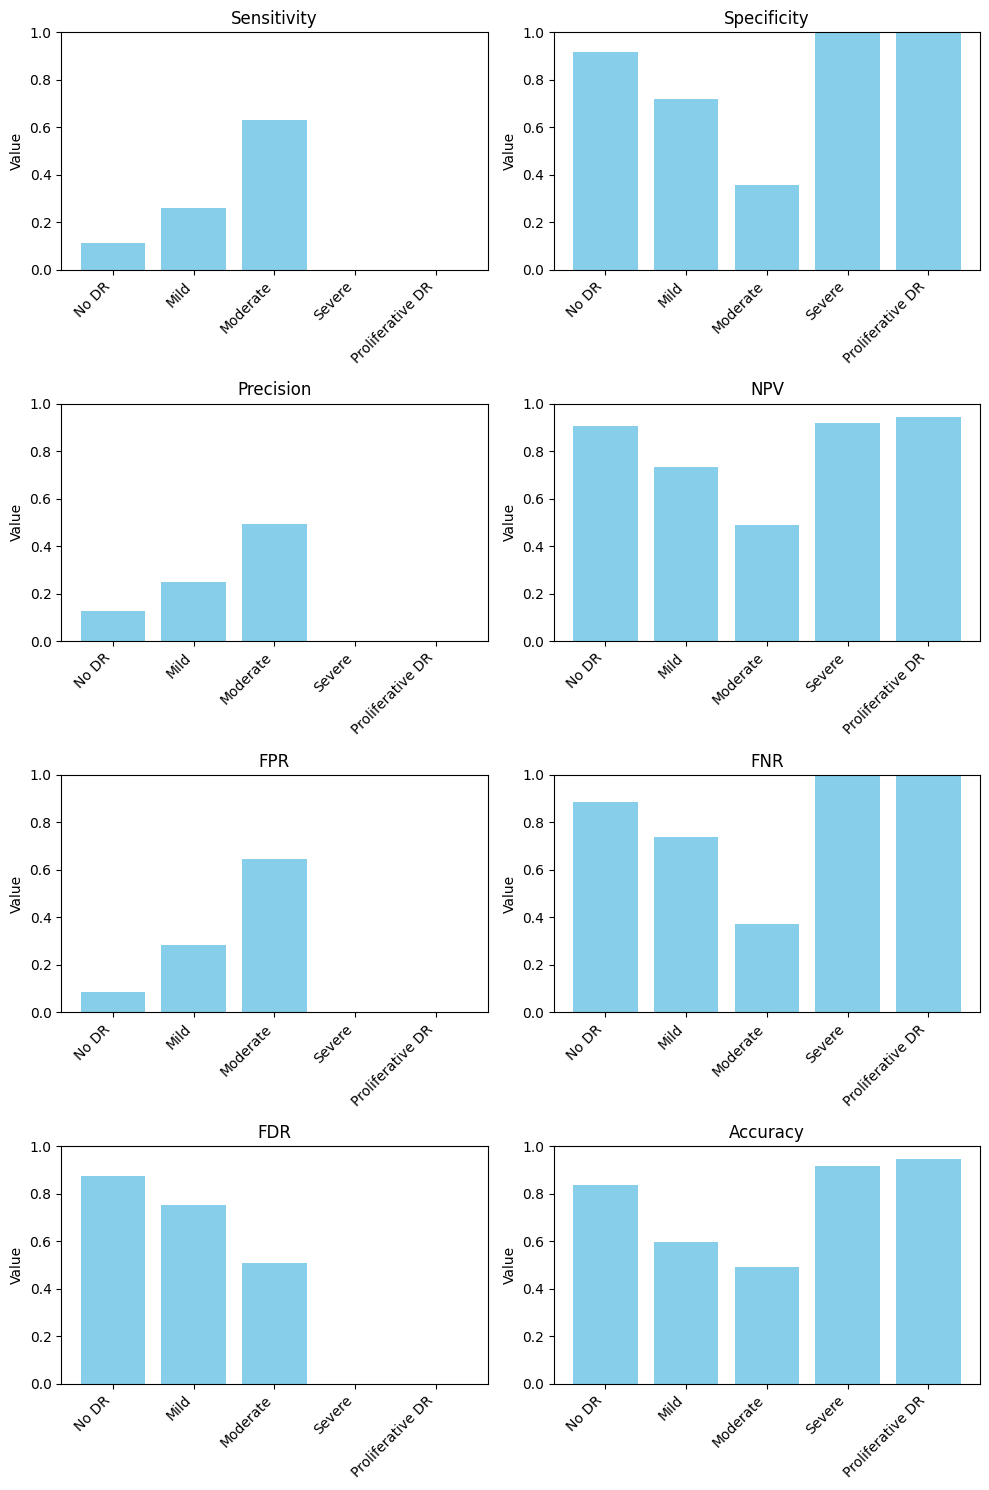

In [63]:
# Metrics to plot
metrics = [TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'NPV', 'FPR', 'FNR', 'FDR', 'Accuracy']

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i], color='skyblue')
    ax.set_title(metric_names[i])
    ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
    ax.set_ylabel('Value')
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

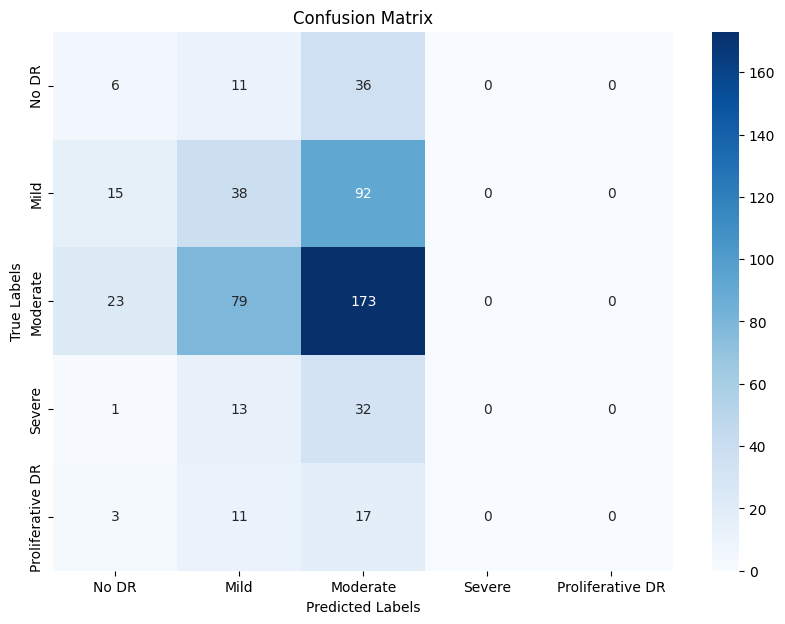

In [64]:
class_labels = class_names

plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Evaluate on secondary DR Detection eyePACS test dataset

In [65]:
eyepacs_df = pd.read_csv('/content/drive/MyDrive/minitest.csv')
eyepacs_df.rename(columns={'image': 'Image', 'level': 'Labels'}, inplace=True)
eyepacs_df['Labels'].replace({0: 'No_DR', 1: 'Mild', 2: 'Moderate', 3: 'Severe', 4: 'Proliferative_DR'}, inplace=True)
eyepacs_df['Image'] = eyepacs_df['Image'] + '.jpeg'
eyepacs_df.head()

Image Labels
0  17123_right.jpeg  No_DR
1  12616_right.jpeg  No_DR
2    6541_left.jpeg  No_DR
3  14418_right.jpeg  No_DR
4   39598_left.jpeg  No_DR

In [66]:
# eyepacs generator

eyepacs_datagen = ImageDataGenerator(rescale = 1./255)

base_path = '/content/drive/My Drive/eyepacs'  # Your base path

eyepacs_generator = eyepacs_datagen.flow_from_dataframe(
    eyepacs_df,
    directory=base_path,  # Updated directory path
    x_col="Image",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32)

Found 1001 validated image filenames belonging to 5 classes.


In [67]:
loss, accuracy, matthews_correlation_coefficient = modelt.evaluate(eyepacs_generator)
print('Test accuracy :', accuracy, 'Test MCC :', matthews_correlation_coefficient)

32/32 [==============================] - 2s 66ms/step - loss: 1.1658 - accuracy: 0.5784 - matthews_correlation_coefficient: -0.0041
Test accuracy : 0.5784215927124023 Test MCC : -0.004101294092833996


In [68]:
# Predict with the model on the test set
predictions = modelt.predict(eyepacs_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Retrieve the true labels from the test generator
true_labels = eyepacs_generator.classes

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=eyepacs_generator.class_indices.keys(),zero_division=0)
print("Classification Report:")
print(report)

# Generate the confusion matrix
epconf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(epconf_matrix)

32/32 [==============================] - 2s 66ms/step
Classification Report:
                  precision    recall  f1-score   support

            Mild       0.00      0.00      0.00        70
        Moderate       0.14      0.24      0.17       151
           No_DR       0.73      0.73      0.73       735
Proliferative_DR       0.00      0.00      0.00        20
          Severe       0.00      0.00      0.00        25

        accuracy                           0.57      1001
       macro avg       0.17      0.19      0.18      1001
    weighted avg       0.56      0.57      0.56      1001

Confusion Matrix:
[[  0  18  52   0   0]
 [  0  36 115   0   0]
 [  2 193 539   1   0]
 [  0   7  13   0   0]
 [  0   7  18   0   0]]


In [69]:
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']

FP = epconf_matrix.sum(axis=0) - np.diag(epconf_matrix)
FN = epconf_matrix.sum(axis=1) - np.diag(epconf_matrix)
TP = np.diag(epconf_matrix)
TN = epconf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)


# Calculate the metrics with conditions to handle division by zero
TPR = np.divide(TP, TP + FN, out=np.zeros_like(TP), where=(TP+FN)!=0)
TNR = np.divide(TN, TN + FP, out=np.zeros_like(TN), where=(TN+FP)!=0)
PPV = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP+FP)!=0)
NPV = np.divide(TN, TN + FN, out=np.zeros_like(TN), where=(TN+FN)!=0)
FPR = np.divide(FP, FP + TN, out=np.zeros_like(FP), where=(FP+TN)!=0)
FNR = np.divide(FN, TP + FN, out=np.zeros_like(FN), where=(TP+FN)!=0)
FDR = np.divide(FP, TP + FP, out=np.zeros_like(FP), where=(TP+FP)!=0)
ACC = np.divide(TP + TN, TP + FP + FN + TN, out=np.zeros_like(TP+TN), where=(TP+FP+FN+TN)!=0)

# Print metrics for each class
for i in range(len(class_names)):
    print(f"Class - {class_names[i]}")
    print(f"  Sensitivity: {TPR[i]}")
    print(f"  Specificity: {TNR[i]}")
    print(f"  Precision: {PPV[i]}")
    print(f"  Negative Predictive Value: {NPV[i]}")
    print(f"  False Positive Rate: {FPR[i]}")
    print(f"  False Negative Rate: {FNR[i]}")
    print(f"  False Discovery Rate: {FDR[i]}")
    print(f"  Overall Accuracy: {ACC[i]}\n")



Class - No DR
  Sensitivity: 0.0
  Specificity: 0.9978517722878625
  Precision: 0.0
  Negative Predictive Value: 0.92992992992993
  False Positive Rate: 0.0021482277121374865
  False Negative Rate: 1.0
  False Discovery Rate: 1.0
  Overall Accuracy: 0.9280719280719281

Class - Mild
  Sensitivity: 0.23841059602649006
  Specificity: 0.7352941176470589
  Precision: 0.13793103448275862
  Negative Predictive Value: 0.8445945945945946
  False Positive Rate: 0.2647058823529412
  False Negative Rate: 0.7615894039735099
  False Discovery Rate: 0.8620689655172413
  Overall Accuracy: 0.6603396603396603

Class - Moderate
  Sensitivity: 0.7333333333333333
  Specificity: 0.2556390977443609
  Precision: 0.7313432835820896
  Negative Predictive Value: 0.25757575757575757
  False Positive Rate: 0.7443609022556391
  False Negative Rate: 0.26666666666666666
  False Discovery Rate: 0.26865671641791045
  Overall Accuracy: 0.6063936063936064

Class - Severe
  Sensitivity: 0.0
  Specificity: 0.99898063200815

<ipython-input-70-86800b8bc2b8>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names, rotation=45, ha='right')


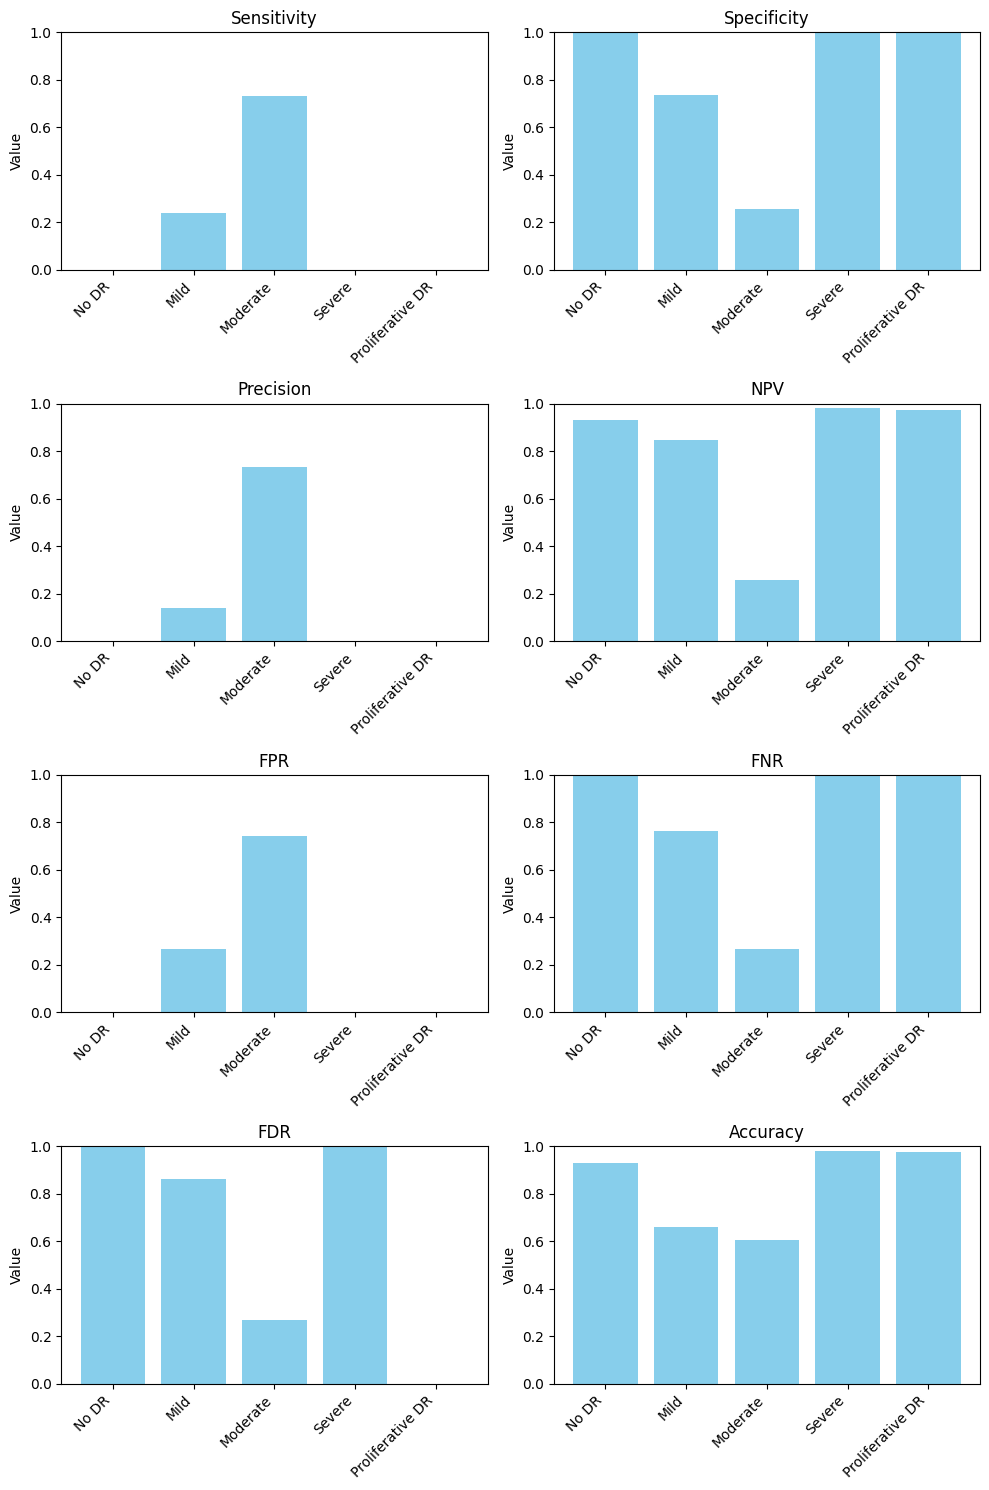

In [70]:
# Metrics to plot
metrics = [TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC]
metric_names = ['Sensitivity', 'Specificity', 'Precision', 'NPV', 'FPR', 'FNR', 'FDR', 'Accuracy']

# Plotting
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Adjust the size as needed
axes = axes.ravel()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i], color='skyblue')
    ax.set_title(metric_names[i])
    ax.set_ylim(0, 1)  # Assuming metrics are between 0 and 1
    ax.set_ylabel('Value')
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()

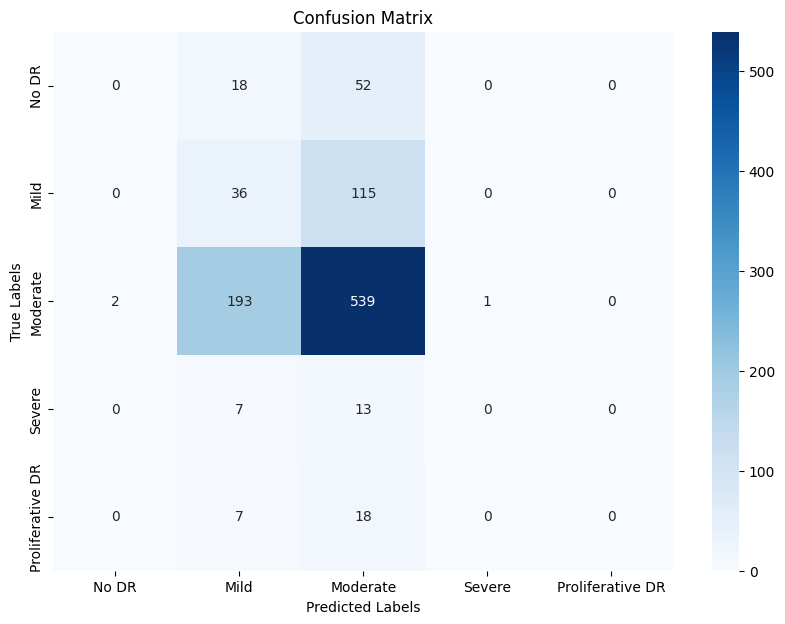

In [71]:
class_labels = class_names

plt.figure(figsize=(10, 7))

# Create a heatmap
sns.heatmap(epconf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()